# Functionality: visualization of functional connectivity

<ul>
    <li>visualize the ciCOH in mild and normal state</li>
</ul>

## Import Packages 

In [1]:
import os, sys
import numpy as np
import pandas as pd

import pickle

from igraph.drawing.text import TextDrawer
import cairo

In [2]:
# import_nbmodule used for import package in .ipynb
import import_nbmodule

# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)


# import animal_folder function in util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import graphVisual in connAnalyTool/graphVisual.pynb 
from connAnalyTool import graphVisual


from simulated.ciCOH_threshold import threshold_ciCOH_sin, corr_threshold_ciCOH_sin_BH

importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/graphVisual.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/simulated/ciCOH_threshold.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/simulated/simulated_timeseries.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/simulated/addnoise.ipynb
importing Jupyter notebook from /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## Preparison

### exp subfolders & code_corresfolder

In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder,correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### global parameters

In [5]:
# frequency
freq = [26, 28]
strfreq = 'freq' + str(freq[0]) + '_' + str(freq[1])
f = (freq[0] + freq[1])//2

# eventphase
event = 'rest'


sameDates4SKTRest = True

In [6]:
### text setup for brain areas ###
texts_area = dict()

texts_area['VPLo'] = [-65, 175, 20]

texts_area['VLo'] = [-65, 240, 20]

texts_area['VA'] = [-65, 300, 20]

texts_area['SMA'] = [120, 500, 20]

texts_area['M1'] = [150, 590, 20]

texts_area['STN'] = [330, 120, 20]

texts_area['GP'] = [430, 280, 20]

pos_text_title = [-40, 60, 30]

pos_text_thred = [-40, 70, 10]

In [7]:
areas_unwanted = ['lCd','rMC']

In [8]:
nfault_thresholdBH = 2

### input setup

In [9]:
inputfolder = os.path.join(correparentfolder, 'm1_avgarea_calcciCOH_avgarea')
filename =  'ciCOH_rest' + '_freq' + str(freq[0]) + '_' + str(freq[1])

    
if sameDates4SKTRest:
    filename = filename + '_samedays'

file = os.path.join(inputfolder, filename + '.pickle')

### save setup

In [10]:
savefolder = corresfolder
savefile_fcgraph_prefix = 'ciCOH_' + event + '_' + strfreq

savefile_hist_prefix = 'hist_' + event + '_' + strfreq
    

In [11]:
filename_threshold = 'threshold' 
savefolder_threshold = os.path.join(savefolder, '..')
file_threshold = os.path.join(savefolder_threshold, filename_threshold + '.pickle')

## pre-visual 

### load ciCOH and Channel

In [12]:
fp = open(file, 'rb')
fc = pickle.load(fp)


# ciCOH_normal, ciCOH_mild: numpy.ndarray(nchns * nchns)
ciCOH_normal, ciCOH_mild  = fc['ciCOH']['normal'], fc['ciCOH']['mild'], 

# channel information chnInf: pandas.core.frame.DataFrame(nchns * 3)
chnInf = fc['chnInf']


ntrials = fc['ntrials']

### del unwanted channels

In [13]:
# extract the indices of unwanted areas
idxs_unwanted = np.empty(shape=[0,], dtype='int32')
for area_unwanted in areas_unwanted:
    
    idx = chnInf.index[area_unwanted == chnInf['chnAreas']].to_numpy(dtype='int32')
    
    idxs_unwanted = np.append(idxs_unwanted, idx, axis = 0)
    
    del idx
    
    
# remove the ciCOH data of the unwanted areas
ciCOH_normal = np.delete(ciCOH_normal, idxs_unwanted, axis = 0)
ciCOH_normal = np.delete(ciCOH_normal, idxs_unwanted, axis = 1)
ciCOH_mild = np.delete(ciCOH_mild, idxs_unwanted, axis = 0)
ciCOH_mild = np.delete(ciCOH_mild, idxs_unwanted, axis = 1)


# remove the chnInf of the unwanted areas
#chnInf = chnInf.drop(idxs_unwanted)


del idxs_unwanted, area_unwanted

### extract chnInf_brainarea 

In [14]:
chnInf = pd.read_csv('areaPos.csv')

In [15]:
### Extract chnInf_brainarea ##

# chnInf_brainarea
chnInf_brainarea = chnInf['chnAreas'].to_list()


# chnInf_coord
x, y = chnInf['coord_x'].to_numpy(), chnInf['coord_y'].to_numpy()
x, y = np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)
chnInf_coord = np.concatenate((x, y), axis = 1)


# chnInf_brainarea and chnInf_recchni
chnInf_brainarea = list()
chnInf_recchni = list()

for chnArea in chnInf['chnAreas'].to_list():
    
    if 'stn' in chnArea:
        chnInf_brainarea.append('STN')
        chnInf_recchni.append(chnArea[3:])
        
    elif 'gp' in chnArea:
        chnInf_brainarea.append('GP')
        
        chnInf_recchni.append(chnArea[2:])
    else:
        if chnArea[0] == 'l' or chnArea[0] == 'r': 
            chnInf_brainarea.append(chnArea[1:])
        else:
            chnInf_brainarea.append(chnArea)
        
        chnInf_recchni.append('')

### calucalte threshold 

In [16]:
ntimes = ciCOH_mild.shape[0] *  ciCOH_mild.shape[1]

In [17]:
## read or calcualte threshold, mu, std ##


df = pd.DataFrame(columns = ['ntimes', 'ntrials', 'f','threshold', 'mu', 'std'])

record_exist = False
if(os.path.exists(file_threshold)):
    # file_threshold exists
    
    # read 
    df = pd.read_pickle(file_threshold)
    
    
    # check if threshold under the ntimes and f exist 
    mask = (df['ntimes'] == ntimes) & (df['ntrials'] == ntrials) & (df['f'] == f)
    
    
    if(df.loc[mask].shape[0] == 1): # record exist
        
        record_exist = True
        
        df1 = df.loc[mask]

        threshold = df1['threshold'].to_numpy()
        mu, std = df1['mu'].to_numpy(), df1['std'].to_numpy()

        del df1
        
if not record_exist: # run threshold_ciCOH_sin if record not exist
    threshold, mu, std = threshold_ciCOH_sin(ntimes = ntimes, ntrials = ntrials, ntemp = 1000, f = f)
    
    
    # store the new record
    thred_sets = dict()
    thred_sets['ntimes'],  thred_sets['ntrials'], thred_sets['f'] = ntimes, ntrials, f
    thred_sets['mu'], thred_sets['std'] = mu, std
    thred_sets['threshold'] = threshold

    df = df.append(thred_sets, ignore_index = True)

    # write to file_threshold
    df.to_pickle(file_threshold)

In [18]:
## correct threshold using BH method ##


# extract ciCOHs_actual as a np.ndarray(nchns * (nchns -1)/2)
nchns = ciCOH_normal.shape[0]
ciCOHs_actual = list()
for chni in range(nchns -1):
    for chnj in range(chni+1, nchns):
        ciCOHs_actual.append(ciCOH_normal[chni][chnj])
        
for chni in range(nchns -1):
    for chnj in range(chni+1, nchns):
        ciCOHs_actual.append(ciCOH_mild[chni][chnj])
        
ciCOHs_actual = np.asarray(ciCOHs_actual)


# false_rate
false_rate = nfault_thresholdBH / ntimes
print("nfalse number = "  + str(nfault_thresholdBH)+ ", false rate = " + str(false_rate))



# corrected threshold using BH method
threshold_BH, _, _ = corr_threshold_ciCOH_sin_BH(ciCOHs_actual = ciCOHs_actual, ntimes = ntimes, ntrials = ntrials, 
                            ntemp = 1000, mu = mu, std = std, f = f, t = 1, false_rate = false_rate)

nfalse number = 2, false rate = 0.003780718336483932
identifying the ciCOH corrected threshold using sinc and Benjamini-Hochberg procedure....
corrected threshold = 0.10108813768720636


## FC Graph

In [19]:
def ciCOH_visual_save(ciCOH, chn_area, chn_coord, str_recchnishow, lowweight, tobesavedfile, texts, threds = None):
    """
        
        Args:
            
            ciCOH (np.sdarray): ciCOH matrix (nchns, nchns)
            
            chn_area (list): a list of string representing brain area for each channel, len(chn_area) = nchns
            
            chn_coord (numpy.ndarray): x, y coordinates for each channel, shape = (nchns, 2)
            
            chn_recchni(list): showed recording chni for each channel, shape = (nchns, )
            
            lowweight: the threshold lowweight, only weight>lowweight is treated as connection
            
            tobesavedfile: file to save the visualized figure
            
            texts:
            
        Output:
            the visualizaton of ciCOH is saved in tobesavedfile
            
    """
    
    weight = abs(ciCOH)

    # weight > lowweight
    weight[np.where(weight<lowweight)] =0
    
    
    # create new graph
    graph = graphVisual.graph_create(weight, vsarea = chn_area, vscoord = chn_coord, vschni = str_recchnishow)

    
    # set graph visualization style
    visual_style = dict()
    if threds is not None:
        colors_opt = ['gray', 'blue' ,'green','red']
        
        colors = ['black'] * len(graph.es['weight'])
        for i, w in enumerate(graph.es['weight']):
            if w > threds[2]: 
                colors[i] = colors_opt[3]
            elif w > threds[1]:
                colors[i] = colors_opt[2]
            elif w > threds[0]:
                colors[i] = colors_opt[1]
                
        visual_style['edge_color'] = colors

    visual_style = graphVisual.graph_style(graph, visual_style)
    

     # plot graph
    igplot = graphVisual.graph_plot(graph, visual_style, texts = texts)
    
    # save graph
    igplot.save(tobesavedfile)
    
    return igplot

In [25]:
# threshold lowweight
lowweight = np.round(threshold_BH, decimals = 2)

if lowweight < threshold_BH:
    lowweight  = np.around(lowweight + 0.01, decimals = 2)

In [26]:
xmax = max(np.amax(abs(ciCOH_normal)), np.amax(abs(ciCOH_mild)))
threds = [lowweight, lowweight + (xmax - lowweight)/3, lowweight + (xmax - lowweight) * 2/3]
threds = np.around(threds, decimals=2)

### normal

In [27]:
"""
    normal condition
"""


condition = 'normal'


# save file config
savefilename = savefile_fcgraph_prefix + '_lowweight' + str(lowweight) + '_' + condition + '.png'
savefile = os.path.join(savefolder, savefilename)

# printed text config
texts = texts_area.copy()

# add condition text
texts[condition] = pos_text_title


text_thred = 'thred = ' + str(lowweight)
texts[text_thred] = pos_text_thred

# visualize and save
igplot = ciCOH_visual_save(ciCOH_normal, 
                           chn_area = chnInf_brainarea, 
                           chn_coord = chnInf_coord,
                           str_recchnishow = chnInf_recchni,
                           lowweight = lowweight,  
                           tobesavedfile = savefile, 
                           texts = texts,
                           threds = threds)

igplot.show()

print("Figure saved to " + savefile)

del condition, savefilename, savefile, texts, igplot

Figure saved to /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/Rest/areabased/m2_avgarea_visual_ciCOH_rest/ciCOH_rest_freq26_28_lowweight0.11_normal.png


### mild

In [28]:
"""
    mild condition
"""


condition = 'mild'


# save file config
savefilename = savefile_fcgraph_prefix + '_lowweight' + str(lowweight) + '_' + condition + '.png'
savefile = os.path.join(savefolder, savefilename)

# printed text config
texts = texts_area.copy()

# add condition text
texts[condition] = pos_text_title


text_thred = 'thred = ' + str(lowweight)
texts[text_thred] = pos_text_thred

# visualize and save
igplot = ciCOH_visual_save(ciCOH_mild, 
                           chn_area = chnInf_brainarea, 
                           chn_coord = chnInf_coord,
                           str_recchnishow = chnInf_recchni,
                           lowweight = lowweight,  
                           tobesavedfile = savefile, 
                           texts = texts,
                           threds = threds)

igplot.show()

print("Figure saved to " + savefile)

del condition, savefilename, savefile, texts, igplot

Figure saved to /home/lingling/Insync/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/NHP_Pinky/1_dataAnaly/FCAnaly/Rest/areabased/m2_avgarea_visual_ciCOH_rest/ciCOH_rest_freq26_28_lowweight0.11_mild.png


## Hist 

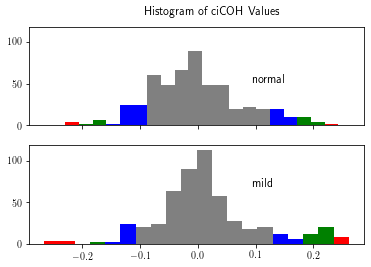

In [29]:
import matplotlib.pyplot as plt

x_normal = np.reshape(ciCOH_normal, (-1))
x_mild = np.reshape(ciCOH_mild, (-1))

colors = ['gray', 'blue' ,'green','red']
labels = ['no sig', 'lower 1/3', 'middle 1/3', 'higher 1/3']



xmax = max(max(abs(x_normal)), max(abs(x_mild)))
xmax = np.around(xmax, decimals=2)
thred0, thred1, thred2 = lowweight, lowweight + (xmax - lowweight)/3, lowweight + (xmax - lowweight) * 2/3




n_bins = 20

fig, axs = plt.subplots(2, 1,  sharex = True, sharey = True)


### normal part ###

N, bins, patches = axs[0].hist(x_normal, bins=n_bins, label = 'normal')


# no  sig part
idx_nosig = np.where(abs(bins)< thred0)[0]
for i in range(len(idx_nosig)):
    
    # len(bins) = len(patches) + 1
    if idx_nosig[i] == len(patches):
        continue
    patches[idx_nosig[i]].set_facecolor(colors[0])

        
# sig part1 
idx_sig = np.where((abs(bins)>=thred0) & (abs(bins)<thred1))[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[1])
    
    
# sig part2 
idx_sig = np.where((abs(bins)>=thred1) & (abs(bins)<thred2))[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[2])
    
    
    
# sig part3 
idx_sig = np.where(abs(bins)>=thred2)[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[3])



xmin, xmax = axs[0].get_xlim() 
ymin, ymax = axs[0].get_ylim()    
axs[0].text(xmin + (xmax - xmin) * 2/3, ymin + (ymax - ymin) * 2/3, 'normal', {'fontsize': 12}, va="top") 
   
    


### mild part ###

N, bins, patches = axs[1].hist(x_mild, bins=n_bins, label = 'mild')


# no  sig part
idx_nosig = np.where(abs(bins)< thred0)[0]
for i in range(len(idx_nosig)):
    
    # len(bins) = len(patches) + 1
    if idx_nosig[i] == len(patches):
        continue
    patches[idx_nosig[i]].set_facecolor(colors[0])

        
# sig part1 
idx_sig = np.where((abs(bins)>=thred0) & (abs(bins)<thred1))[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[1])
    
    
# sig part2 
idx_sig = np.where((abs(bins)>=thred1) & (abs(bins)<thred2))[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[2])
    
    
    
# sig part3 
idx_sig = np.where(abs(bins)>=thred2)[0]
for i in range(len(idx_sig)):
    
    # len(bins) = len(patches) + 1
    if idx_sig[i] == len(patches):
        continue
    patches[idx_sig[i]].set_facecolor(colors[3])



    
xmin, xmax = axs[1].get_xlim() 
ymin, ymax = axs[1].get_ylim()    
axs[1].text(xmin + (xmax - xmin) * 2/3, ymin + (ymax - ymin) * 2/3, 'mild', {'fontsize': 12}, va="top") 

title = 'Histogram of ciCOH Values' 
fig.suptitle(title, x = 0.55, y= 0.95, weight = 'bold')


plt.savefig(os.path.join(savefolder, savefile_hist_prefix + title + '.png'))